In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [2]:
# Load and preprocess data
def load_and_preprocess_data(file_path, target_column):
    data = pd.read_csv(file_path)
    X = data.drop(target_column, axis=1)
    y = data[target_column]
    
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns
    
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])
    
    X_processed = preprocessor.fit_transform(X)
    
    return train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [3]:
# Objective function for evaluation
def evaluate_model(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    return scores.mean()

In [4]:
# Bayesian Optimization
def gp_minimize_custom(objective, param_space, n_calls=50, random_state=None):
    np.random.seed(random_state)
    best_params = None
    best_score = np.inf
    
    for _ in range(n_calls):
        params = [np.random.uniform(low=low, high=high) for low, high in param_space]
        score = objective(params)
        if score < best_score:
            best_score = score
            best_params = params
    
    return {'params': best_params, 'score': best_score}

In [5]:
# Random Forest-based Optimization
def forest_minimize_custom(objective, param_space, n_calls=50, random_state=None):
    np.random.seed(random_state)
    best_params = None
    best_score = np.inf
    
    for _ in range(n_calls):
        params = [np.random.uniform(low=low, high=high) for low, high in param_space]
        score = objective(params)
        if score < best_score:
            best_score = score
            best_params = params
    
    return {'params': best_params, 'score': best_score}

In [6]:
# Tree-Parzen Estimator (TPE)
def tpe_minimize_custom(objective, param_space, max_evals=50, random_state=None):
    np.random.seed(random_state)
    best_params = None
    best_score = np.inf
    
    for _ in range(max_evals):
        params = [np.random.uniform(low=low, high=high) for low, high in param_space]
        score = objective(params)
        if score < best_score:
            best_score = score
            best_params = params
    
    return {'params': best_params, 'score': best_score}

In [7]:
def plot_hyperparameter_optimization_results(results):
    plt.figure(figsize=(12, 6))
    for label, result in results.items():
        best_params = result['params']
        if len(best_params) == 2:
            plt.scatter(best_params[0], best_params[1], label=label, s=100)
        else:
            plt.scatter(best_params[0], 0, label=label, s=100)  # Single parameter models
    plt.xlabel('Parameter 1')
    plt.ylabel('Parameter 2')
    plt.legend()
    plt.show()


Please enter the path to the data file:  ../diabetes.csv
Please enter the target column name:  Outcome
Please enter the model name (RandomForest, LogisticRegression, SVM, GradientBoosting):  SVM


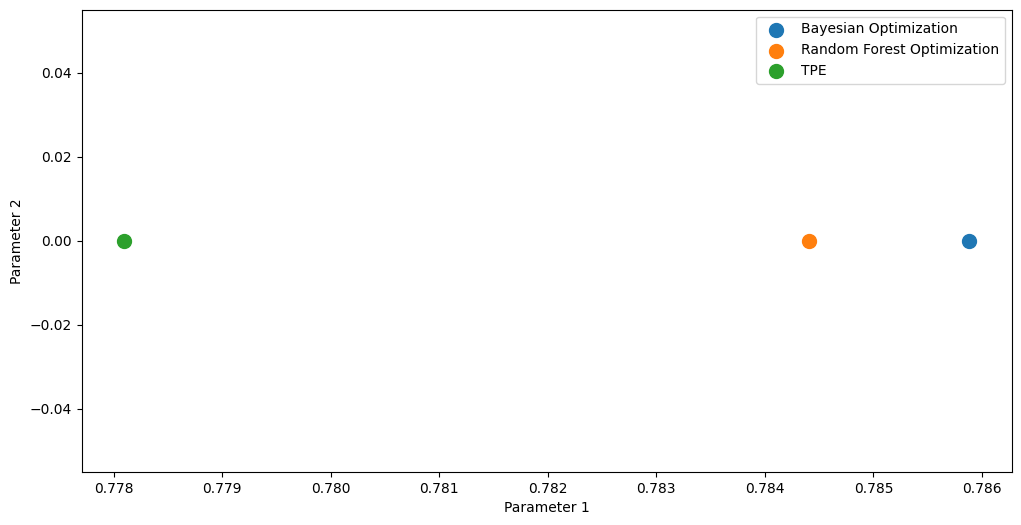

Test ROC AUC: 0.8068870523415977


In [8]:
def main(file_path, target_column, model_name):
    # Load and preprocess data
    X_train, X_test, y_train, y_test = load_and_preprocess_data(file_path, target_column)
    
    # Define models and their respective parameter spaces
    models = {
        'RandomForest': (RandomForestClassifier(random_state=42), [(10, 100), (2, 20)]),
        'LogisticRegression': (LogisticRegression(max_iter=1000, random_state=42), [(0.001, 1.0)]),  # C parameter
        'SVM': (SVC(probability=True, random_state=42), [(0.001, 1.0)]),  # C parameter
        'GradientBoosting': (GradientBoostingClassifier(random_state=42), [(10, 100), (0.01, 1.0)])  # n_estimators and learning_rate
    }
    
    # Select model and parameter space based on user input
    model, param_space = models[model_name]
    
    def objective(params):
        if model_name == 'RandomForest':
            model.set_params(n_estimators=int(params[0]), min_samples_split=int(params[1]))
        elif model_name in ['LogisticRegression', 'SVM']:
            model.set_params(C=params[0])
        elif model_name == 'GradientBoosting':
            model.set_params(n_estimators=int(params[0]), learning_rate=params[1])
        return -evaluate_model(model, X_train, y_train)
    
    # Bayesian Optimization
    bayes_results = gp_minimize_custom(objective, param_space)
    
    # Random Forest-based Optimization
    rf_results = forest_minimize_custom(objective, param_space)
    
    # Tree-Parzen Estimator (TPE)
    tpe_results = tpe_minimize_custom(objective, param_space)
    
    # Visualize hyperparameter optimization results
    results = {
        'Bayesian Optimization': bayes_results,
        'Random Forest Optimization': rf_results,
        'TPE': tpe_results
    }
    plot_hyperparameter_optimization_results(results)
    
    for label, result in results.items():
        best_params = result['params']
    
    # Highlight the best result
    best_result = max(results.values(), key=lambda x: x['score'])
    best_params = best_result['params']
    
    # Final model training and evaluation
    if model_name == 'RandomForest':
        model.set_params(n_estimators=int(best_params[0]), min_samples_split=int(best_params[1]))
    elif model_name in ['LogisticRegression', 'SVM']:
        model.set_params(C=best_params[0])
    elif model_name == 'GradientBoosting':
        model.set_params(n_estimators=int(best_params[0]), learning_rate=best_params[1])
        
    model.fit(X_train, y_train)
    test_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f'Test ROC AUC: {test_score}')

# Example usage
file_path = input("Please enter the path to the data file: ")
target_column = input("Please enter the target column name: ")
model_name = input("Please enter the model name (RandomForest, LogisticRegression, SVM, GradientBoosting): ")
main(file_path, target_column, model_name)